In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels as sm

In [2]:
df = pd.read_feather('output_files\cleaned_data.feather')

correct_dtypes = {
	'station_id': 'int32',
	'direction': 'category',
	'delay_in_minutes': 'int16'
}

df = df.query('direction == "dep"').astype(correct_dtypes)
print(df.shape)
df.head(5)

(7018, 17)


,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city,line_type,delay_reason_1,delay_reason_2,delay_reason_3
8,Änderung im Fahrtverlauf!@@Grund: Verzögerung...,15:57,ICE 1002,München Hbf 15:56-Nürnberg Hbf 16:58-Bamberg17...,8000261,dep,Berlin Gesundbrunnen,19,15:56,20.06.19,Muenchen%238000261,1,Muenchen,ICE,Änderung im Fahrtverlauf!,Verzögerungen im Betriebsablauf,nan
16,Änderung im Fahrtverlauf!@@Grund: Technische ...,11:05,ICE623,Köln Hbf10:41-Köln Messe/Deutz10:42-Köln/Bonn ...,8000207,dep,München Hbf,5 D-G,10:41,20.06.19,Koeln%238000207,24,Koeln,ICE,Änderung im Fahrtverlauf!,Technische Störung am Zug,Gleiswechsel
23,Änderung im Fahrtverlauf!@@Grund: Polizeilich...,17:35,ICE651,Hannover Hbf 17:31-Wolfsburg Hbf18:02-Berlin-S...,8000152,dep,Berlin Gesundbrunnen,9,17:31,20.06.19,Hannover%238000152,4,Hannover,ICE,Änderung im Fahrtverlauf!,Polizeiliche Ermittlung,nan
27,Änderung im Fahrtverlauf!@@Grund: Notarzteins...,23:46,ICE877,Frankfurt(Main)Hbf 23:00-Frankfurt(M) Flughafe...,8000105,dep,Karlsruhe Hbf,6,23:00,20.06.19,Frankfurt%238000105,46,Frankfurt,ICE,Änderung im Fahrtverlauf!,Notarzteinsatz am Gleis,nan
31,Änderung im Fahrtverlauf!@@Ersatzfahrt für IC...,20:24,ICE 2910,Hannover Hbf 19:37-Lüneburg 20:26-Hamburg-Harb...,8000152,dep,Kiel Hbf,7,19:37,20.06.19,Hannover%238000152,47,Hannover,ICE,Änderung im Fahrtverlauf!,Ersatzfahrt,Zusätzlicher Halt zum Ein- /Ausstieg für Reisende


# Data Analysis

## 1. Question
Are there any lines that are more likely to be late?

<AxesSubplot: title={'center': 'Total number of rides per Line Type'}>

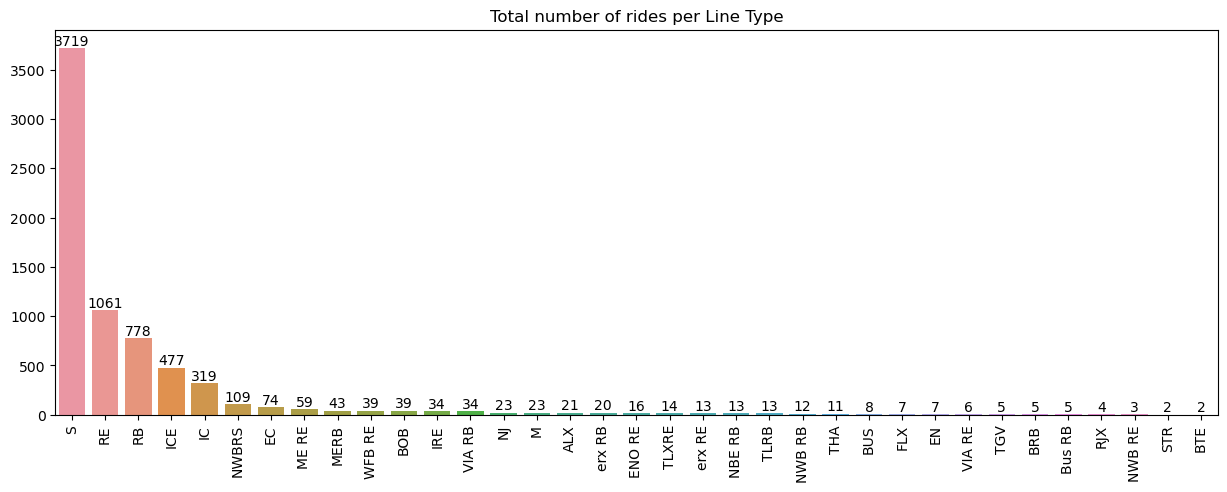

In [14]:
fig,ax = plt.subplots(1,1, figsize=(15,5))

sns.barplot(x=df['line_type'].value_counts().index, y=df['line_type'].value_counts()).set(title='Total number of rides per Line Type', ylabel=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);

for i in ax.containers:
    ax.bar_label(i,)

sns.lineplot()

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Number of rides per Line Type</font></h3>
    
<li> For a statistical inference there should be more than 30 samples, as such the analysis will continue with the line types that had more than 30 rides
</div>

In [15]:
mask_lines_with_more_than_x_rides = (df['line_type'].value_counts() > 30)
lines_with_more_than_x_rides = mask_lines_with_more_than_x_rides[mask_lines_with_more_than_x_rides].index
df_more_than_x_rides = df[df['line_type'].isin(lines_with_more_than_x_rides)]

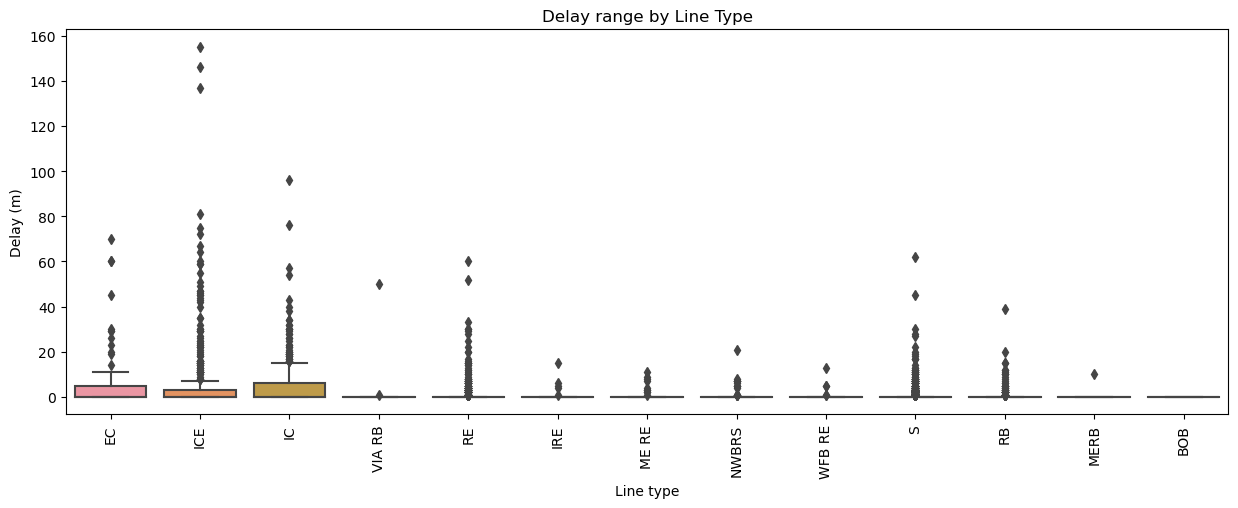

In [16]:
fig,ax = plt.subplots(1,1, figsize=(15,5))

sort_line_type_by_q75 = (df_more_than_x_rides[['delay_in_minutes', 'line_type']].groupby('line_type')
	.mean()
	.sort_values(by='delay_in_minutes', ascending=False)
	.index)

sorted_df = df_more_than_x_rides.copy()
sorted_df['line_type'] = pd.Categorical(sorted_df['line_type'], sort_line_type_by_q75)

sns.boxplot(data=sorted_df, x='line_type', y='delay_in_minutes', ax=ax)\
	.set(title='Delay range by Line Type', ylabel='Delay (m)', xlabel='Line type')

ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);

(0.0, 20.0)

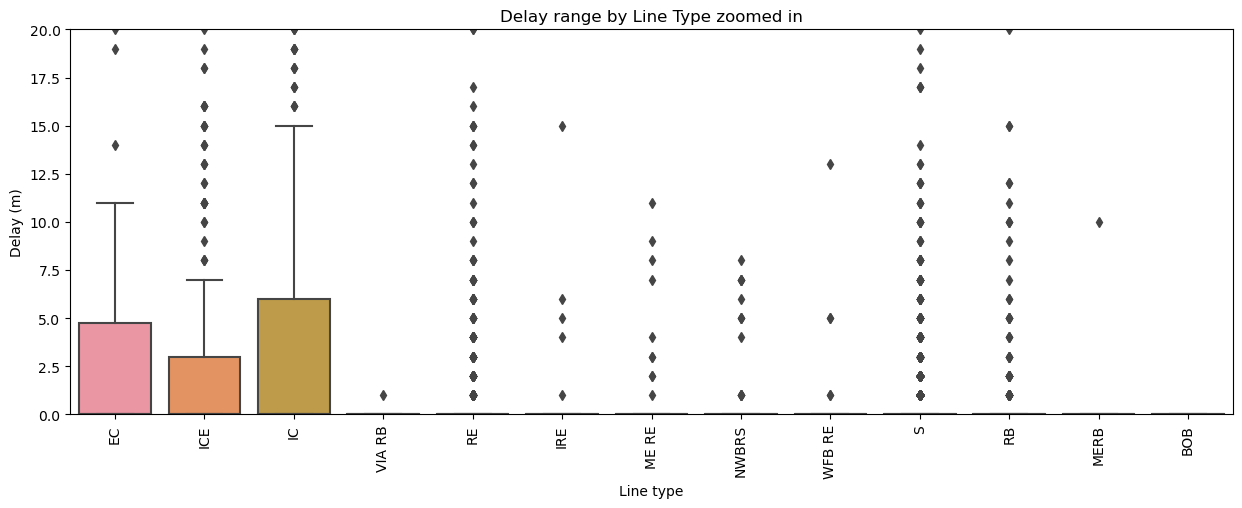

In [17]:
fig,ax = plt.subplots(1,1, figsize=(15,5))

sns.boxplot(data=sorted_df, x='line_type', y='delay_in_minutes')\
	.set(title='Delay range by Line Type zoomed in', ylabel='Delay (m)', xlabel='Line type')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);
ax.set_ylim([0, 20])

In [18]:
array_delays = sorted_df[['line_type', 'delay_in_minutes']]\
    .fillna(0)\
    .pivot(columns='line_type', values='delay_in_minutes')\
    .to_dict(orient='list')

array_delays = {x:np.array(y)[~np.isnan(y)] for x, y in array_delays.items()}

array_delays.keys()

dict_keys(['EC', 'ICE', 'IC', 'VIA RB', 'RE', 'IRE', 'ME RE', 'NWBRS', 'WFB RE', 'S', 'RB', 'MERB', 'BOB'])

In [19]:
df_array = [[],[],[],[]]

for i_df, col in enumerate(array_delays):
	df_array[0].append(stats.shapiro(array_delays[col]).pvalue)
	df_array[1].append(df_array[0][i_df] > 0.05)
	df_array[2].append(stats.shapiro(np.log1p(array_delays[col])).pvalue)
	df_array[3].append(df_array[1][i_df] > 0.05)

indexes = ['p_val', 'Parametric?', 'p_val of log', 'Parametric?']

print('Shapiro test')
pd.DataFrame(df_array, columns=array_delays.keys(), index=indexes)

Shapiro test


c:\Users\Kriggs\miniconda3\envs\DataAnalysis\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,EC,ICE,IC,VIA RB,RE,IRE,ME RE,NWBRS,WFB RE,S,RB,MERB,BOB
p_val,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Parametric?,False,False,False,False,False,False,False,False,False,False,False,False,True
p_val of log,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Parametric?,False,False,False,False,False,False,False,False,False,False,False,False,True


In [20]:
print('Kruskal-Wallis H-test')
p_val_kruskal = stats.kruskal(*[array_delays[x] for x in array_delays]).pvalue
print('p_val:',p_val_kruskal)
print('Are all populations the same?', 'No.' if p_val_kruskal < 0.05 else 'Yes.')

Kruskal-Wallis H-test
p_val: 9.216457641520338e-84
Are all populations the same? No.


In [24]:
def t_test_table(samples: dict):
    sample_names = list(samples.keys())
    results = pd.DataFrame(index=sample_names, columns=sample_names).fillna(-1)
    for i, sample1 in enumerate(sample_names):
        for j, sample2 in enumerate(sample_names[i+1:]):
            t_stat, p_value = stats.mannwhitneyu(samples[sample1], samples[sample2], alternative='greater')
            results.loc[sample1, sample2] = p_value
    return results

results = t_test_table(array_delays)

def highlight_cells(val):
    color = ''
    font_color = ''

    if val == -1:
        color = '#4D4D4D'
        font_color = '#4D4D4D'
    elif val < 0.05:
        color = '#FF9B9B'
        font_color = 'black'

    return f'background-color: {color}; color: {font_color}'

# H0: mu_row == mu_column
# Ha: mu_row < mu_column
print('Mann-Whitney U test (Confidence=95%)')
print('Red coloured cells means the line on the row is slower than the line on the column')


results.style.applymap(highlight_cells)

Mann-Whitney U test (Confidence=95%)
Red coloured cells means the line on the row is slower than the line on the column


,EC,ICE,IC,VIA RB,RE,IRE,ME RE,NWBRS,WFB RE,S,RB,MERB,BOB
EC,-1,0.114611,0.629419,0.000074,0.000000,0.001703,0.000303,0.000004,0.000337,0.000000,0.000000,0.000002,0.000001
ICE,-1,-1.000000,0.996346,0.000220,0.000000,0.004804,0.000843,0.000003,0.001016,0.000000,0.000000,0.000006,0.000004
IC,-1,-1.000000,-1.000000,0.000008,0.000000,0.000210,0.000006,0.000000,0.000024,0.000000,0.000000,0.000000,0.000000
VIA RB,-1,-1.000000,-1.000000,-1.000000,0.964980,0.882210,0.935766,0.907415,0.837701,0.967734,0.753657,0.217626,0.066090
RE,-1,-1.000000,-1.000000,-1.000000,-1.000000,0.344001,0.457335,0.216812,0.203800,0.345159,0.000000,0.004537,0.001783
IRE,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.598384,0.500000,0.394229,0.637938,0.135374,0.025400,0.007149
ME RE,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.342169,0.285124,0.497060,0.024561,0.011361,0.003602
NWBRS,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.376111,0.767841,0.037016,0.017497,0.005940
WFB RE,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.789015,0.235089,0.038477,0.011207
S,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.004004,0.001531


In [22]:
describe_line_types = df_more_than_x_rides[['line_type', 'delay_in_minutes']]\
    .pivot(columns='line_type', values='delay_in_minutes')\
    [results.columns]\
	.describe()

lower_bound = list(describe_line_types.loc['mean'] - 1.96 * describe_line_types.loc['std'] / np.sqrt(describe_line_types.loc['count']))
upper_bound = list(describe_line_types.loc['mean'] + 1.96 * describe_line_types.loc['std'] / np.sqrt(describe_line_types.loc['count']))
upper_lower_bound_index = ['CI 95% - Upper Bound', 'CI 95% - Lower Bound']

df_upper_lower = pd.DataFrame(np.reshape([upper_bound, lower_bound], (2,-1)), columns=describe_line_types.columns, index=upper_lower_bound_index)

describe_line_types = pd.concat([df_upper_lower, describe_line_types])
describe_line_types

line_type,EC,ICE,IC,VIA RB,RE,IRE,ME RE,NWBRS,WFB RE,S,RB,MERB,BOB
CI 95% - Upper Bound,10.193474,7.471707,6.835486,4.381182,1.199664,1.881642,1.442713,1.297340,1.369949,0.577981,0.536720,0.688372,0.0
CI 95% - Lower Bound,3.482202,4.482172,4.368276,-1.381182,0.724936,-0.058113,0.252202,0.298991,-0.087898,0.442186,0.237059,-0.223256,0.0
count,74.000000,477.000000,319.000000,34.000000,1061.000000,34.000000,59.000000,109.000000,39.000000,3719.000000,778.000000,43.000000,39.0
mean,6.837838,5.976939,5.601881,1.500000,0.962300,0.911765,0.847458,0.798165,0.641026,0.510083,0.386889,0.232558,0.0
std,14.727690,16.656234,11.241270,8.571447,3.944723,2.885362,2.332777,2.658947,2.322512,2.112577,2.132227,1.524986,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,4.750000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,70.000000,155.000000,96.000000,50.000000,60.000000,15.000000,11.000000,21.000000,13.000000,62.000000,39.000000,10.000000,0.0


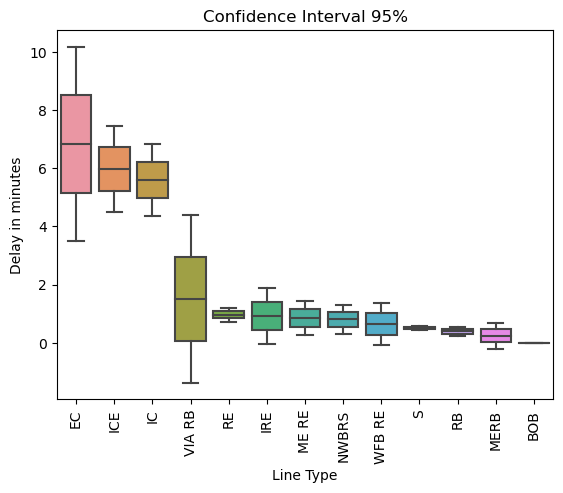

In [23]:
ax = sns.boxplot(df_upper_lower)
ax.set(title='Confidence Interval 95%', ylabel='Delay in minutes', xlabel='Line Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Statistical inference for train types</font></h3>
    
<li> BOB (Bayerische Oberlandbahn) was the only line that didn't had delays
<li> The lines IC (Intercity), ICE (Inter City Express) and EC(Eurocity) have, according to Mann-Whitney U and the confidence interval, consistently longer delays than the rest of the lines
<li> For the other lines we can't affirm one or another was often more delayed, although the Whitney-U says some are worse than others, the confidence intervals put them at just 15 seconds difference
</div>